In [1]:
import torch
import scanpy as sc


In [2]:
adata = sc.read("processed_files/glutamatergic.h5ad")

In [9]:
sc.pp.highly_variable_genes(adata, n_top_genes=2500, subset=True)

In [10]:
X = adata.X

AnnData object with n_obs × n_vars = 282930 × 2500
    obs: 'APOE_class', 'Brain.Region', 'SORT', 'Braak.stage', 'Disease.Group', 'Amyloid', 'Brain.weight', 'PMI.hr.', 'Race', 'Age', 'RIN', 'total_counts', 'pct_counts_mt', 'droplet_FDR', 'doublefinder', 'n_genes', 'sample', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'donor_id', 'Age_group', 'PMI_group', 'RIN_group', 'Major_celltypes', 'Author_Annotation', 'NP.Diagonis', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'mt', 'ribo', 'hb', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Amyloid_colors',

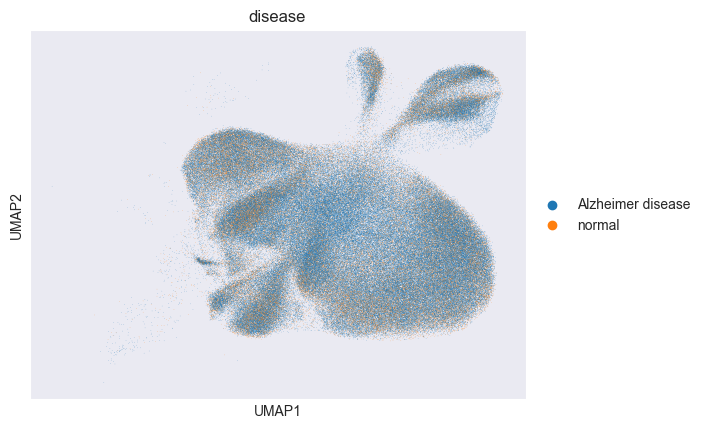

In [12]:
sc.pl.umap(adata, color="disease")

In [ ]:
import scvelo as scv
scv.pp.filter_and_normalize(adata)
scv.pp.moments(adata)
scv.tl.velocity(adata)
scv.tl.velocity_graph(adata)
scv.tl.velocity_pseudotime(adata)
scv.pl.velocity_embedding_stream(adata, color='cell_type')